# ConvNet implementation

### Data Preprocessing

In [170]:
import os
import cv2
import numpy as np
from tqdm import tqdm # throw info during iteration

REBUILD_DATA = True # Change to True for generating the numpy file with the preprocessed data!

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    dataset = []
    catcount = 0
    dogcount = 0
    errors = 0

    def make_dataset(self):
        for label in self.LABELS:
            for file in tqdm(os.listdir(label)): # iterate each file in the specific directory
                try:
                    path = os.path.join(label,file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.dataset.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS: self.catcount += 1
                    elif label == self.DOGS: self.dogcount += 1
                
                except Exception as e:
                    self.errors += 1
                    #print(e) 

        np.save("dataset.npy", self.dataset)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")
        print(f"Errors: {self.errors}")

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_dataset()

dataset = np.load("dataset.npy", allow_pickle=True)

100%|██████████| 12501/12501 [00:09<00:00, 1354.98it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (24946, 2) + inhomogeneous part.

In [77]:
dataset.shape

(24946, 2)

### Loading preprocessed data 

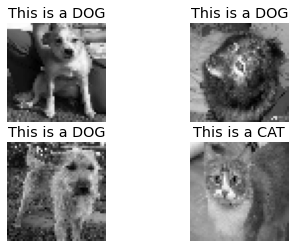

In [80]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(2,2)

for i in range(2):
    for j in range(2):
        N = np.random.randint(dataset.shape[0])
        img = dataset[N,0]
        ohe = dataset[N,1]
        if ohe[0] == 1:
            label = "CAT"
        else: 
            label = "DOG"
        ax[i,j].imshow(img, cmap = 'gray')
        ax[i,j].set_title(f'This is a {label}')
        ax[i,j].grid(False)
        ax[i,j].axis(False)

plt.show()   


In [160]:
l = [i for i in dataset]
print(l[0])

type(dataset)

[array([[ 93,  96, 107, ..., 124, 113, 103],
        [ 97, 107, 117, ..., 129, 123, 108],
        [105, 118, 125, ..., 132, 127, 115],
        ...,
        [122, 130, 138, ..., 107, 139, 118],
        [120, 130, 136, ..., 110, 118, 111],
        [116, 118, 128, ..., 101,  94,  97]], dtype=uint8) array([1., 0.])]


numpy.ndarray

In [163]:
print(dataset.dtype)
training_ds = torch.tensor(dataset)

print(training_ds)

object


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

## Data split

In [151]:
import torch
import numpy as np

X = torch.Tensor([i[0] for i in dataset]).reshape(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in dataset])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

X_train, y_train = X[:-val_size], y[:-val_size]
X_test,  y_test  = X[-val_size:], y[-val_size:]

print(f'training size: {len(X_train)}\ntesting size: {len(X_test)}')

training size: 22452
testing size: 2494


## Is CUDA available ?

In [87]:
torch.cuda.is_available()

True

### Assigning GPU to device

In [88]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("running on the GPU :)")
else: 
    device = torch.device('cpu')
    print("running on the CPU :(")

running on the GPU :)


### Number of GPUs

In [89]:
torch.cuda.device_count()

1

# Transfer the DNN to the GPU

In [130]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# device = torch.device('cuda:0')

class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 64, kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.30)

        self.fc1 = nn.Linear(in_features = 22*22*128,   out_features = 128)
        self.fc2 = nn.Linear(in_features = 128,         out_features = 2)
    
    def forward(self, t):

        t = self.conv1(t)
        t = F.relu(t)
        t = self.dropout1(t)

        t = self.conv2(t)
        t = F.relu(t)
        t = self.dropout2(t)
        
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t,2)

        t = torch.flatten(t,1)
        
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.softmax(t, dim=1)
        
        return t

## Inspecting layers 

In [99]:
# Acess to layers (attributes of the class Net)
print(f'ConLayer: {net.conv2}\n')

# Access to weights of a specific layer
print(f'ConLayer weights: {net.conv2.weight}\n')

# Access to the bias of a specific layer
print(f'ConvLayer bias: {net.conv2.bias}\n')

# Get the shape of tensor weights
print(f'Shape of ConLayer weights: {net.conv2.weight.shape}\n')

# Get the shape of tensor bias
print(f'Shape of ConLayer bias: {net.conv2.bias.shape}\n')

ConLayer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))

ConLayer weights: Parameter containing:
tensor([[[[-1.5190e-02,  3.6813e-02,  5.6494e-02],
          [-2.9301e-02,  4.2539e-02,  4.0677e-03],
          [-4.9815e-02,  2.3792e-02,  1.3440e-02]],

         [[ 3.7340e-02, -1.4507e-02, -3.6410e-02],
          [-1.3056e-02,  4.4163e-02, -6.7667e-03],
          [-5.3454e-02,  3.8445e-02,  3.9543e-02]],

         [[ 4.2261e-02, -1.7229e-02,  1.6069e-02],
          [-4.9299e-02, -4.0058e-03, -4.0489e-02],
          [ 2.7811e-03,  2.8556e-02,  3.0333e-03]],

         ...,

         [[ 3.2022e-02,  3.2457e-02,  1.8551e-02],
          [ 4.4877e-02,  1.5112e-02, -1.7698e-02],
          [ 5.8197e-02, -1.7744e-02, -2.2298e-02]],

         [[-4.3476e-02, -1.0851e-02, -3.3706e-02],
          [ 3.7427e-02,  2.7230e-02, -3.3800e-02],
          [ 5.3804e-02,  3.1459e-02, -1.0396e-02]],

         [[ 5.7284e-02,  3.7720e-02, -7.4535e-03],
          [ 5.0410e-02,  5.3909e-02,  1.1421e-02],
       

## Disable 'set_grad_enabled' when not training to reduce memory consumption

In [100]:
torch.set_grad_enabled(False)

## The network always expect a **BATCH** (ex: array of images)

In [131]:
net = Net()
#net.cuda()

## The input tensor must be of rank 4
- [BATCH, CHANNEL, HEIGHT, WIDTH]
- Example: a batch of 10 images, which have 3 channels (RGB) and a resolution of 50x50 pixels.

- Example below
    - A batch of 1 image, which has 1 channel GRAYSCALE, and a resolution of 50 x 50 pixels

In [126]:
img = train_X[0].unsqueeze(0).unsqueeze(0)
print(img.shape)

torch.Size([1, 1, 50, 50])


## Compute a prediction

In [149]:
pred = net(img)
print(pred)
print(pred.argmax(dim = 1)[0])

tensor([[0.4749, 0.5251]])
tensor(1)


## Enable for training

In [150]:
torch.set_grad_enabled(True)

## Training

In [ ]:
# Create the batchs
BATCH_SIZE = 10
from torch.utils.data import DataLoader
train_loader = DataLoader(X_train, batch_size = BATCH_SIZE, shuffle=True)
batch = next(iter(train_loader))

In [40]:
import os
import cv2
import numpy as np
import torch.optim as optim
from tqdm import tqdm # throw info during iteration

BATCH_SIZE = 10
EPOCHS = 5

def train(net):
    optm_func = optim.Adam(net.parameters(), lr=0.001)
    loss_func = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_func(outputs, batch_y)
            loss.backward()
            optm_func.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)

100%|██████████| 2246/2246 [00:26<00:00, 84.29it/s]


Epoch: 0. Loss: 0.032770298421382904


100%|██████████| 2246/2246 [00:27<00:00, 82.87it/s]


Epoch: 1. Loss: 0.013093516230583191


100%|██████████| 2246/2246 [00:27<00:00, 82.07it/s]


Epoch: 2. Loss: 0.00022947356046643108


100%|██████████| 2246/2246 [00:27<00:00, 81.92it/s]


Epoch: 3. Loss: 0.0017225682968273759


100%|██████████| 2246/2246 [00:27<00:00, 82.09it/s]

Epoch: 4. Loss: 6.064270201022737e-05


## Testing 

In [41]:
def test(net):    
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))

test(net)

100%|██████████| 2494/2494 [00:02<00:00, 1089.76it/s]

Accuracy:  0.728


In [ ]:
0.718

In [42]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
    
def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)]

    acc = matches.count(True)/len(matches)

    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [43]:
# size: samples of the test dataset
def test(size=32):
    random_start = np.random.randint(len(test_X) - size)
    X, y = test_X[:size], test_y[:size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.75 tensor(0.2217, device='cuda:0')


In [44]:
import time

MODEL_NAME = f'model-{int(time.time())}'

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 10
    EPOCHS = 10

    with open('model.log', "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0,len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if i % 50 == 0:
                    val_acc, val_loss = test(size = 100)
                    f.write(f'{MODEL_NAME},{round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss),4)}, {round(float(val_acc),2)}, {round(float(val_loss),4)}\n')

train()

model-1646703582


100%|██████████| 2246/2246 [00:38<00:00, 58.99it/s]


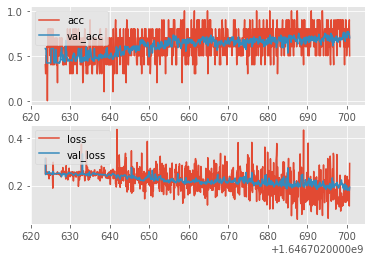

In [45]:
import matplotlib.pyplot as plt
from matplotlib import style 

style.use("ggplot")

model_name = "model-1646702623"

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split('\n')

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents: 
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(',')

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    
    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
    
    ax1.plot(times,accuracies, label = "acc")
    ax1.plot(times,val_accs, label = "val_acc")
    ax1.legend(loc=2)

    ax2.plot(times,losses, label = "loss")
    ax2.plot(times,val_losses, label = "val_loss")
    ax2.legend(loc=2)    
    
    plt.show
        
create_acc_loss_graph(model_name)

